In [1]:
import pulp 

In [2]:
GB = 2 ** 30
T = 1e12

# constants
# OPT-30B
h = 7168 
l = 48 

m = 1 # minibatch num

class Bandwidths:
    c2g = 24 * GB 
    g2c = 24 * GB 
    c2d = 1 * GB 
    d2c = 3 * GB 

B_type = 2 # for fp16
class FLOPS:
    mm = {2: 200 * T}

class MemCap: 
    gmem: int = 24 * GB     # Nvidia 4090
    cmem: int = 220 * GB    # 
    dmem: int = 3000 * GB 



In [3]:
class AttrDict(dict):
    """Sub-classes dict, and further allows attribute-like access to dictionary items.

    Examples:
        >>> d = AttrDict({'a': 1})
        >>> d.a, d['a'], d.get('a')
        (1, 1, 1)
        >>> d.b = 2
        >>> d.b, d['b']
        (2, 2)
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__dict__ = self

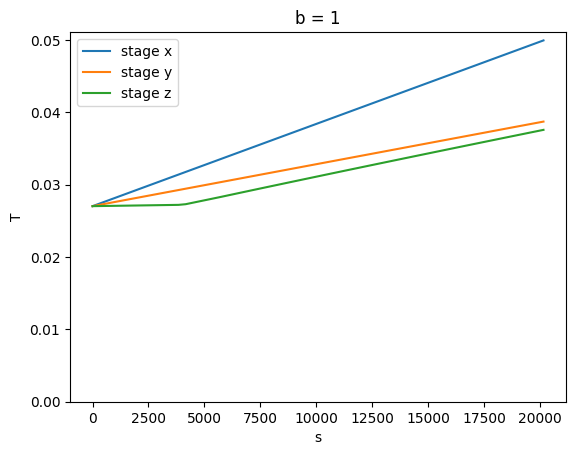

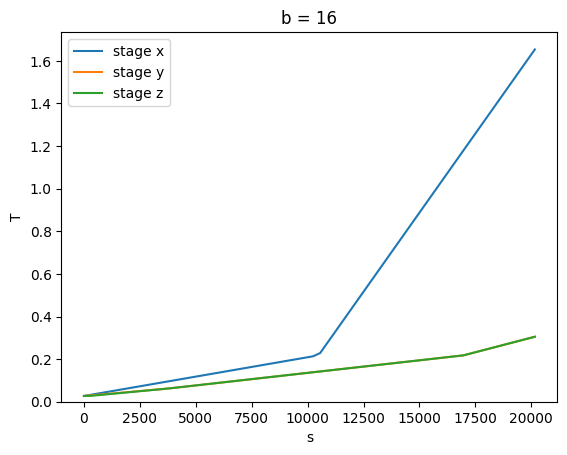

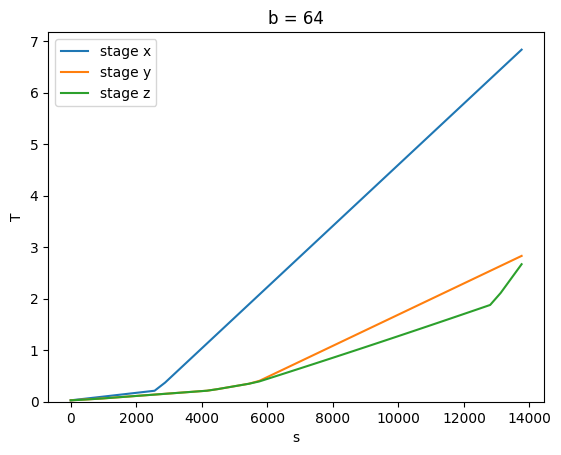

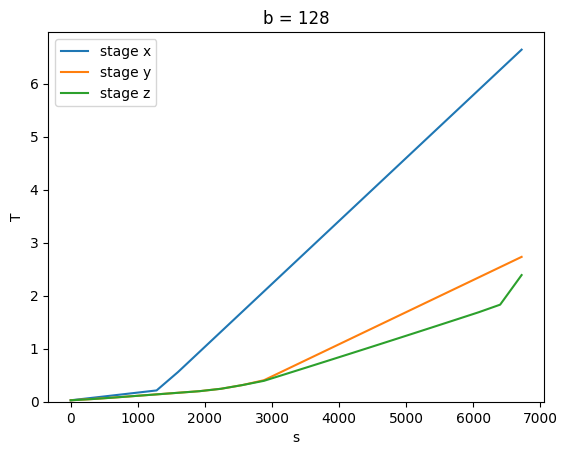

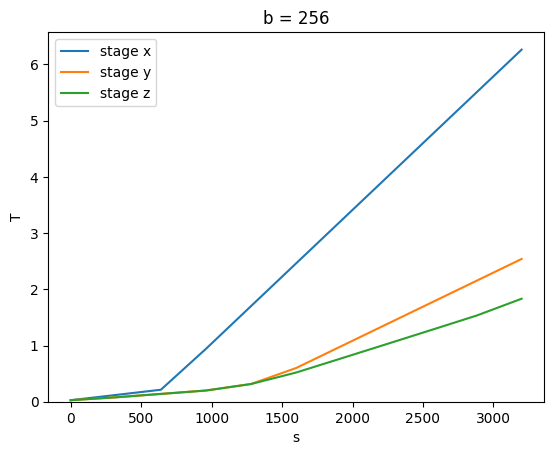

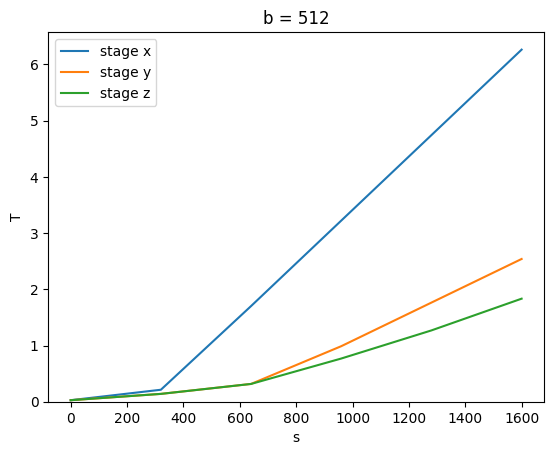

In [4]:
def lp(b, s, stage='z', verbose=False):
    assert stage in ['x', 'y', 'z'] 

    prob = pulp.LpProblem(name='SARecomp', sense=pulp.LpMinimize)

    # w, x, y, z refer to weights, kv cache, actv cache, recomputed actv

    # percents
    pxg = pulp.LpVariable('pxg', 0, 1)
    pxc = pulp.LpVariable('pxc', 0, 1)
    pxd = pulp.LpVariable('pxd', 0, 1)
    pyg = pulp.LpVariable('pyg', 0, 1)
    pyc = pulp.LpVariable('pyc', 0, 1)
    pyd = pulp.LpVariable('pyd', 0, 1)
    pz = pulp.LpVariable('pz', 0, 1)

    if stage == 'x':
        prob += pxg + pxc + pxd == 1
    elif stage == 'y':
        prob += pxg + pxc + pxd + pyg + pyc + pyd == 1 
    elif stage == 'z':
        prob += pxg + pxc + pxd + pyg + pyc + pyd + pz == 1 

    pwg = pulp.LpVariable('pwg', 0, 1)
    pwc = pulp.LpVariable('pwc', 0, 1)
    pwd = pulp.LpVariable('pwd', 0, 1)
    prob += pwg + pwc + pwd == 1 

    # c2g, g2c, c2d, d2c, comp

    # dm: data movement, T: time 
    dm_c2g = pulp.LpVariable('dm_c2g', 0)
    T_c2g = pulp.LpVariable('T_c2g', 0)
    prob += dm_c2g == 12 / m * h ** 2 * (pwc + pwd) + 2 * b * s * h * (pxc + pxd) + b * s * h * (pyc + pyd) 
    prob += T_c2g == dm_c2g * (B_type / Bandwidths.c2g) 

    dm_g2c = pulp.LpVariable('dm_g2c', 0)
    T_g2c = pulp.LpVariable('T_g2c', 0)
    prob += dm_g2c == 2 * b * 1 * h * (pxc + pxd) + b * 1 * h * (pyc + pyd) 
    prob += T_g2c == dm_g2c * (B_type / Bandwidths.g2c) 

    dm_d2c = pulp.LpVariable('dm_d2c', 0)
    T_d2c = pulp.LpVariable('T_d2c', 0)
    prob += dm_d2c == 12 /m * h ** 2 * (0 + pwd) + 2 * b * s * h * (0 + pxd) + b * s * h * (0 + pyd) 
    prob += T_d2c == dm_d2c * (B_type / Bandwidths.d2c )

    dm_c2d = pulp.LpVariable('dm_c2d', 0)
    T_c2d = pulp.LpVariable('T_c2d', 0)
    prob += dm_c2d == 2 * b * 1 * h * (0 + pxd) + b * 1 * h * (0 + pyd) 
    prob += T_c2d == dm_c2d * (B_type / Bandwidths.c2d) 

    x = pulp.LpVariable('x', 0)
    y = pulp.LpVariable('y', 0)
    z = pulp.LpVariable('z', 0)
    prob += x == s * (pxg + pxc + pxd)
    prob += y == s * (pyg + pyc + pyd)
    prob += z == s * pz 

    comp = pulp.LpVariable('comp', 0)
    prob += comp == 2 * (2 * b * y * h ** 2 + 2 * b * s * h * (z + 1) + 12 * b * (z + 1) * h ** 2)
    T_comp = pulp.LpVariable('T_comp', 0)
    prob += T_comp == (1 / FLOPS.mm[B_type]) * (2 * (2 * b * y * h ** 2 + 2 * b * s * h * (z + 1) + 12 * b * (z + 1) * h ** 2))
    # prob += T_comp == (1 / FLOPS.mm[B_type]) * comp


    # T_ovl = max(T_c2g, T_g2c, T_d2c, T_c2d, T_comp)
    T_ovl = pulp.LpVariable('T_ovl', 0)
    prob += (T_ovl >= T_c2g)
    prob += (T_ovl >= T_g2c)
    prob += (T_ovl >= T_d2c)
    prob += (T_ovl >= T_c2d)
    prob += (T_ovl >= T_comp) 

    # mem cap constraints
    G_home = pulp.LpVariable('G_home', 0)
    C_home = pulp.LpVariable('C_home', 0)
    D_home = pulp.LpVariable('D_home', 0)
    prob += G_home == l * (12 * h ** 2 * pwg + 2 * b * s * h * pxg + b * s * h * pyg) * B_type
    prob += C_home == l * (12 * h ** 2 * pwc + 2 * b * s * h * pxc + b * s * h * pyc) * B_type
    prob += D_home == l * (12 * h ** 2 * pwd + 2 * b * s * h * pxd + b * s * h * pyd) * B_type

    G_tmp1 = pulp.LpVariable('G_tmp1', 0)
    G_tmp2 = pulp.LpVariable('G_tmp2', 0)
    prob += G_tmp1 == (2 * b * s * h + b * (z + 1) * h) * B_type # KV fully loaded in GPU
    # prob += G_tmp1 == (0 * b * s * h + b * z * h) * B_type # KV not fully loaded in GPU
    prob += G_tmp2 == 4 * b * (z + 1) * h * B_type # ffn hidden

    G_tmp = pulp.LpVariable('G_tmp', 0)
    prob += (G_tmp >= G_tmp1)
    prob += (G_tmp >= G_tmp2) 

    C_tmp = pulp.LpVariable('C_tmp', 0) # load from disk
    prob += C_tmp == 1 * (12 * h ** 2 * pwd + 2 * b * s * h * pxd + b * s * h * pyd) * B_type

    prob += (G_home + G_tmp <= MemCap.gmem)
    prob += (C_home + C_tmp <= MemCap.cmem)
    prob += (D_home <= MemCap.dmem) 

    # obj
    prob += T_ovl 
    status = prob.solve(pulp.PULP_CBC_CMD(msg=verbose))

    out = AttrDict() 
    out.b = b
    out.s = s
    out.status = pulp.LpStatus[status]
    out.stage = stage 
    out.T = T_ovl.value()
    out.x = x.value()
    out.y = y.value()
    out.z = z.value()
    out.Ts = [t.value() for t in [T_c2g, T_g2c, T_d2c, T_c2d, T_comp]]

    out.comp_debug = comp.value() / FLOPS.mm[B_type]
    out.T_comp = T_comp.value()

    out.dm_c2g_debug = dm_c2g.value() * (B_type / Bandwidths.c2g)
    out.T_c2g = T_c2g.value()

    out.dm_g2c_debug = dm_g2c.value() * (B_type / Bandwidths.g2c)
    out.T_g2c = T_g2c.value()

    out.dm_d2c_debug = dm_d2c.value() * (B_type / Bandwidths.d2c)
    out.T_d2c = T_d2c.value()

    out.dm_c2d_debug = dm_c2d.value() * (B_type / Bandwidths.c2d)
    out.T_c2d = T_c2d.value()


    out.pw = [x.value() for x in [pwg, pwc, pwd]]
    out.px = [x.value() for x in [pxg, pxc, pxd]]
    out.py = [x.value() for x in [pyg, pyc, pyd]]
    out.pz = [x.value() for x in [pz]]
    
    out.G_peak = (G_home.value() + G_tmp.value()) / GB 
    out.C_peak = (C_home.value() + C_tmp.value()) / GB 
    out.D_peak = (D_home.value() + 0) / GB 


    # print(out)
    # return 

    # out.vars = [(v.name, v.varValue) for v in prob.variables()]


    if verbose: 
        print(out)

    return out

import matplotlib.pyplot as plt 
%matplotlib inline 

s_upper = 20 * 1024
s_step = s_upper // 64
for b in [1, 16, 64, 128, 256, 512]:
    Ox, Oy, Oz = [], [], []
    ss = range(0, s_upper, s_step)
    for s in ss:
        outx = lp(b, s, 'x')
        outy = lp(b, s, 'y')
        outz = lp(b, s, 'z')
        # print(outx, outy, outz, sep='\n', end='\n\n')

        Ox.append(outx)
        Oy.append(outy)
        Oz.append(outz)

    plt.plot(ss, [o.T if o.status == 'Optimal' else None for o in Ox],  label='stage x')
    plt.plot(ss, [o.T if o.status == 'Optimal' else None for o in Oy],  label='stage y')
    plt.plot(ss, [o.T if o.status == 'Optimal' else None for o in Oz],  label='stage z')
    plt.xlabel('s')
    plt.ylabel('T')
    plt.legend()
    plt.title(f"{b = }")
    plt.gca().set_ylim(bottom=0)
    plt.show()


In [5]:
# def lp(b, s, stage='z', verbose=False):
#     assert stage in ['x', 'y', 'z'] 

#     prob = pulp.LpProblem(name='SARecomp', sense=pulp.LpMinimize)

#     # w, x, y, z refer to weights, kv cache, actv cache, recomputed actv

#     # percents
#     pxg = pulp.LpVariable('pxg', 0, 1)
#     pxc = pulp.LpVariable('pxc', 0, 1)
#     pxd = pulp.LpVariable('pxd', 0, 1)
#     pyg = pulp.LpVariable('pyg', 0, 1)
#     pyc = pulp.LpVariable('pyc', 0, 1)
#     pyd = pulp.LpVariable('pyd', 0, 1)
#     pz = pulp.LpVariable('pz', 0, 1)

#     if stage == 'x':
#         prob += pxg + pxc + pxd == 1
#     elif stage == 'y':
#         prob += pxg + pxc + pxd + pyg + pyc + pyd == 1 
#     elif stage == 'z':
#         prob += pxg + pxc + pxd + pyg + pyc + pyd + pz == 1 

#     pwg = pulp.LpVariable('pwg', 0, 1)
#     pwc = pulp.LpVariable('pwc', 0, 1)
#     pwd = pulp.LpVariable('pwd', 0, 1)
#     prob += pwg + pwc + pwd == 1 

#     # c2g, g2c, c2d, d2c, comp

#     # dm: data movement, T: time 
#     dm_c2g = pulp.LpVariable('dm_c2g', 0)
#     T_c2g = pulp.LpVariable('T_c2g', 0)
#     prob += dm_c2g == 12 * h ** 2 * (pwc + pwd) + 2 * b * s * h * (pxc + pxd) + b * s * h * (pyc + pyd) 
#     prob += T_c2g == dm_c2g * (B_type / Bandwidths.c2g) 

#     dm_g2c = pulp.LpVariable('dm_g2c', 0)
#     T_g2c = pulp.LpVariable('T_g2c', 0)
#     prob += dm_g2c == 2 * b * 1 * h * (pxc + pxd) + b * 1 * h * (pyc + pyd) 
#     prob += T_g2c == dm_g2c * (B_type / Bandwidths.g2c) 

#     dm_d2c = pulp.LpVariable('dm_d2c', 0)
#     T_d2c = pulp.LpVariable('T_d2c', 0)
#     prob += dm_d2c == 12 * h ** 2 * (0 + pwd) + 2 * b * s * h * (0 + pxd) + b * s * h * (0 + pyd) 
#     prob += T_d2c == dm_d2c * (B_type / Bandwidths.d2c )

#     dm_c2d = pulp.LpVariable('dm_c2d', 0)
#     T_c2d = pulp.LpVariable('T_c2d', 0)
#     prob += dm_c2d == 2 * b * 1 * h * (0 + pxd) + b * 1 * h * (0 + pyd) 
#     prob += T_c2d == dm_c2d * (B_type / Bandwidths.c2d) 

#     y = pulp.LpVariable('y', 0)
#     z = pulp.LpVariable('z', 0)
#     prob += y == s * (pyg + pyc + pyd)
#     prob += z == s * pz 

#     comp = pulp.LpVariable('comp', 0)
#     T_comp = pulp.LpVariable('T_comp', 0)
#     prob += comp == 2 * (2 * b * y * h ** 2 + 2 * b * s * h * (z + 1) + 12 * b * (z + 1) * h ** 2)
#     prob += T_comp == (1. / FLOPS.mm[B_type]) * (2 * (2 * b * y * h ** 2 + 2 * b * s * h * (z + 1) + 12 * b * (z + 1) * h ** 2)) # 

#     T_ovl = pulp.LpVariable('T_ovl', 0)
#     prob += (T_ovl >= T_c2g)
#     prob += (T_ovl >= T_g2c)
#     prob += (T_ovl >= T_d2c)
#     prob += (T_ovl >= T_c2d)
#     prob += (T_ovl >= T_comp) 

#     # mem cap constraints
#     G_home = pulp.LpVariable('G_home', 0)
#     C_home = pulp.LpVariable('C_home', 0)
#     D_home = pulp.LpVariable('D_home', 0)
#     prob += G_home == l * (12 * h ** 2 * pwg + 2 * b * s * h * pxg + b * s * h * pyg) * B_type
#     prob += C_home == l * (12 * h ** 2 * pwc + 2 * b * s * h * pxc + b * s * h * pyc) * B_type
#     prob += D_home == l * (12 * h ** 2 * pwd + 2 * b * s * h * pxd + b * s * h * pyd) * B_type

#     G_tmp1 = pulp.LpVariable('G_tmp1', 0)
#     G_tmp2 = pulp.LpVariable('G_tmp2', 0)
#     prob += G_tmp1 == (2 * b * s * h + b * z * h) * B_type # KV fully loaded in GPU
#     # prob += G_tmp1 == (0 * b * s * h + b * z * h) * B_type # KV not fully loaded in GPU
#     prob += G_tmp2 == 4 * b * z * h * B_type # ffn hidden

#     G_tmp = pulp.LpVariable('G_tmp', 0)
#     prob += (G_tmp >= G_tmp1)
#     prob += (G_tmp >= G_tmp2) 

#     C_tmp = pulp.LpVariable('C_tmp', 0)
#     prob += C_tmp == 1 * (12 * h ** 2 * pwd + 2 * b * s * h * pxd + b * s * h * pyd) * B_type

#     prob += (G_home + G_tmp <= MemCap.gmem)
#     prob += (C_home + C_tmp <= MemCap.cmem)
#     prob += (D_home <= MemCap.dmem) 

#     # obj
#     prob += T_ovl 
#     status = prob.solve(pulp.PULP_CBC_CMD(msg=verbose))

#     out = AttrDict() 
#     out.b = b
#     out.s = s
#     out.status = pulp.LpStatus[status]
#     out.stage = stage 
#     out.T = T_ovl.value()
#     out.Ts = [t.value() for t in [T_c2g, T_g2c, T_d2c, T_c2d, T_comp]]
#     out.comp = comp.value()
#     out.T_comp = T_comp.value()
#     out.pw = [x.value() for x in [pwg, pwc, pwd]]
#     out.px = [x.value() for x in [pxg, pxc, pxd]]
#     out.py = [x.value() for x in [pyg, pyc, pyd]]
#     out.pz = [x.value() for x in [pz]]
    
#     out.G_peak = (G_home.value() + G_tmp.value()) / GB 
#     out.C_peak = (C_home.value() + C_tmp.value()) / GB 
#     out.D_peak = (D_home.value() + 0) / GB 

#     # out.vars = [(v.name, v.varValue) for v in prob.variables()]


#     if verbose: 
#         print(out)

#     return out

# import matplotlib.pyplot as plt 
# %matplotlib inline 

# s_upper = 2 * 1024
# s_step = 256
# for b in [1, 16, 64, 128, 256, 512]:
#     Ox, Oy, Oz = [], [], []
#     ss = range(100, s_upper, s_step)
#     for s in ss:
#         outx = lp(b, s, 'x')
#         outy = lp(b, s, 'y')
#         outz = lp(b, s, 'z')
#         print(outx, outy, outz, sep='\n', end='\n\n')

#         Ox.append(outx)
#         Oy.append(outy)
#         Oz.append(outz)

#     plt.plot(ss, [o.T if o.status == 'Optimal' else None for o in Ox],  label='stage x')
#     plt.plot(ss, [o.T if o.status == 'Optimal' else None for o in Oy],  label='stage y')
#     plt.plot(ss, [o.T if o.status == 'Optimal' else None for o in Oz],  label='stage z')
#     plt.xlabel('s')
#     plt.ylabel('T')
#     plt.legend()
#     plt.title(f"{b = }")
#     # plt.gca().set_ylim(bottom=0)
#     plt.show()

#     # plt.plot(ss, [o.G_peak for o in Ox], label='x')
#     # plt.plot(ss, [o.G_peak for o in Oy], label='y')
#     # plt.plot(ss, [o.G_peak for o in Oz], label='z')
#     # plt.legend()
#     # plt.title(f"G_peak ({b = })")
#     # plt.show()

#     # plt.plot(ss, [o.C_peak for o in Ox], label='x')
#     # plt.plot(ss, [o.C_peak for o in Oy], label='y')
#     # plt.plot(ss, [o.C_peak for o in Oz], label='z')
#     # plt.legend()
#     # plt.title(f"C_peak ({b = })")
#     # plt.show()

#     # plt.plot(ss, [o.D_peak for o in Ox], label='x')
#     # plt.plot(ss, [o.D_peak for o in Oy], label='y')
#     # plt.plot(ss, [o.D_peak for o in Oz], label='z')
#     # plt.legend()
#     # plt.title(f"D_peak ({b = })")
#     # plt.show()